In [217]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from eccoseas.downscale import hFac
import pandas as pd

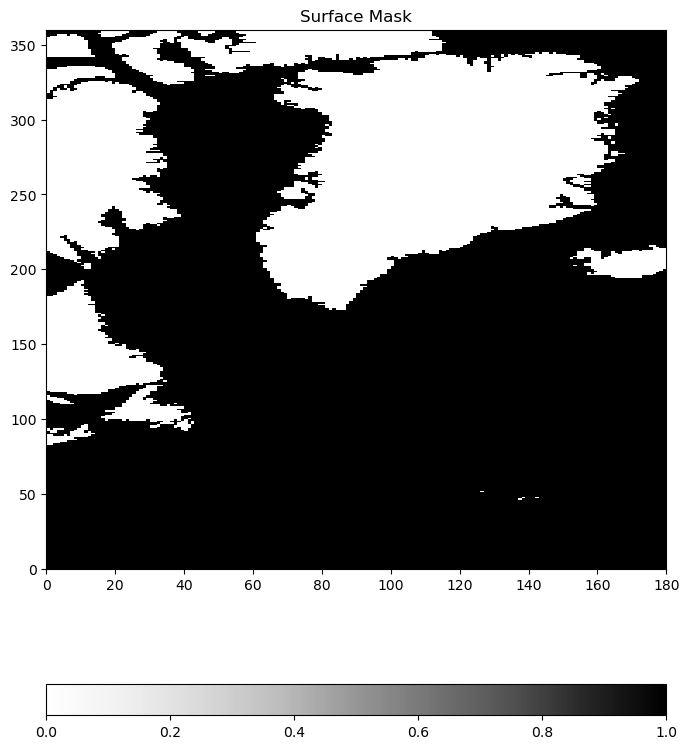

In [218]:
input_dir = '/Users/eddie/IcebergModeling/Input'

# define the parameters that will be used in the data file
n_rows = 360
n_cols = 180

model_grid = np.fromfile(os.path.join(input_dir,'greenland.mitgrid'),'>f8').reshape((16, n_rows+1, n_cols+1))
# recreate the grids that will be used in the model
XC = model_grid[0,:-1,:-1]
YC = model_grid[1,:-1,:-1]

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))
surface_mask = hFac.create_surface_hFacC_grid(bathy, delR=1)

plt.figure(figsize=(8,10))

# plt.subplot(1,1,2)
C = plt.pcolormesh(surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

In [219]:
center = (275, 130)
coastline_points = []

for i in range(160, 310):  # we don't care about edge points. Also, avoid northern points as conflicted with Canada mainlands
    for j in range(50, n_cols - 1):
        if surface_mask[i][j]:
            # First quadrant (bottom-right)
            if i > center[0] and j > center[1]:  
                if surface_mask[i][j - 1] == 0 and surface_mask[i][j + 1] == 1:
                    coastline_points.append([i,j])
                elif surface_mask[i - 1][j] == 0 and surface_mask[i + 1][j] == 1:
                    coastline_points.append([i,j])

            # Second quadrant (bottom-left)
            elif i > center[0] and j < center[1]:  
                if surface_mask[i][j - 1] == 1 and surface_mask[i][j + 1] == 0:
                    coastline_points.append([i,j])
                elif surface_mask[i - 1][j] == 0 and surface_mask[i + 1][j] == 1:
                    coastline_points.append([i,j])

            # Third quadrant (top-left)
            elif i < center[0] and j < center[1]:  
                if surface_mask[i][j - 1] == 1 and surface_mask[i][j + 1] == 0:
                    coastline_points.append([i,j])
                elif surface_mask[i - 1][j] == 1 and surface_mask[i + 1][j] == 0:
                    coastline_points.append([i,j])

            # Fourth quadrant (top-right)
            elif i < center[0] and j > center[1]:  
                if i < 220 and j > 145:
                    continue
                if surface_mask[i][j - 1] == 0 and surface_mask[i][j + 1] == 1:
                    coastline_points.append([i,j])
                elif surface_mask[i - 1][j] == 1 and surface_mask[i + 1][j] == 0:
                    coastline_points.append([i,j])



In [220]:
def draw_coastlines(coastline_points, i):
    mask = surface_mask.copy()
    for point in coastline_points:
        mask[point[0]][point[1]] = 2
    fig, ax = plt.subplots(figsize=(8, 10))
    
    C = ax.pcolormesh(mask, vmin=0, vmax=2, cmap='Greys')
    plt.colorbar(C, orientation='horizontal', ax=ax)
    ax.set_title('Surface Mask')
    plt.close(fig)
    return fig

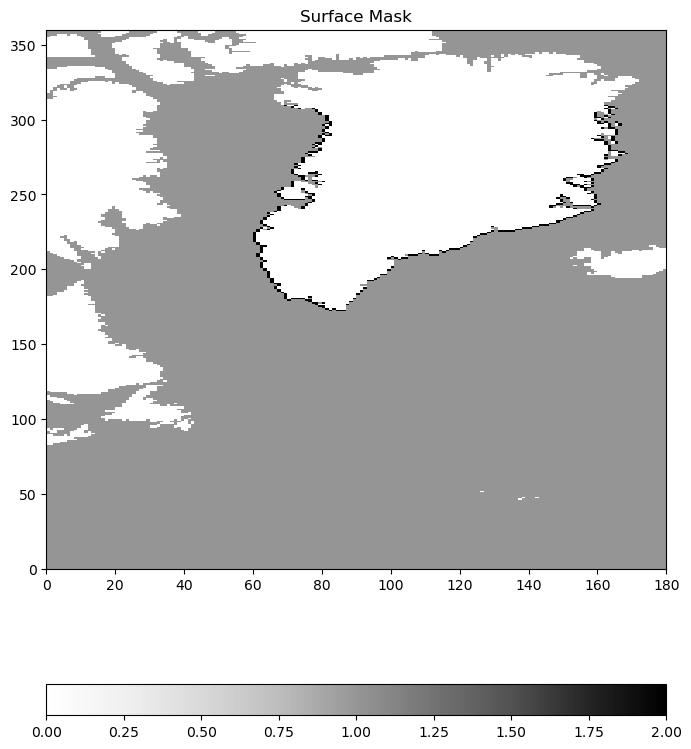

In [221]:
draw_coastlines(coastline_points,-1)

In [222]:
from PIL.ImageQt import rgb
import plotly.graph_objects as go
import numpy as np

def draw_coastlines_plotly(coastline_points, i):
    mask = surface_mask.copy()
    for point in coastline_points:
        mask[point[0]][point[1]] = 2
    fig, ax = plt.subplots(figsize=(8, 10))
    
    fig = go.Figure()

    fig.add_trace(go.Heatmap(
        z=mask,
        # color='size',
        zmin=0, zmax=2,
        colorbar=dict(orientation='h', title="Surface Mask")
    ))

    fig.update_layout(
        title="Surface Mask",
        width=600, height=800
    )

    return fig  # Return the Plotly figure object


   1.0   73.0  180.0
   2.0   82.0  290.0
   3.0   67.0  239.0
   4.0  146.0  241.0
   5.0   79.0  263.0


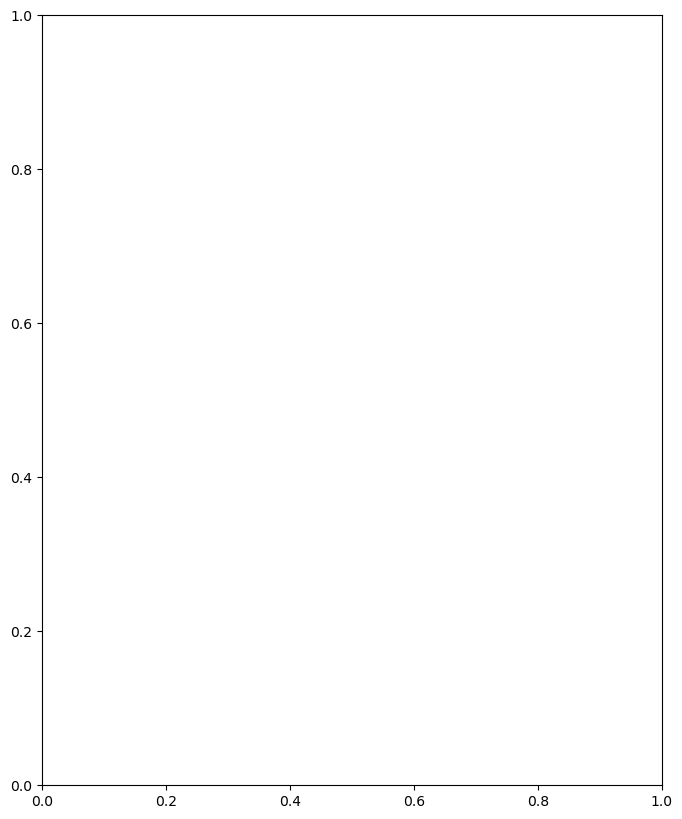

In [285]:
# fig = draw_coastlines_plotly(coastline_points, 0)
num_of_sample = 5
arr_2d = np.array(coastline_points) # Example: 10 rows, 2 columns (x, y points)
random_index = np.random.choice(range(len(arr_2d)), num_of_sample, replace=False)  # Select row indices
random_points = [arr_2d[i] for i in random_index]

txt = "  {index:4.1f}  {col:5.1f}  {row:5.1f}"
for i in range(5):
    print(txt.format(index=i+1, row=random_points[i][0], col=random_points[i][1]))
    
draw_coastlines_plotly(random_points, 0)

In [286]:
with open('calving_locations.txt', 'w') as file:
    if file is None:
        raise FileNotFoundError("File not found.")
    for i in range(5):
        random_point = random_points[i]
        str_output = txt.format(index=i+1, row=random_point[0] + 1, col=random_point[1] + 1)
        if i < 4: 
            file.write(str_output + '\n')
        else:
            file.write(str_output)

A file of n random points across the coastline of Greenland was created

In [287]:
for point in random_points:
    print(bathy[point[0], point[1]])

-144.0
-178.0
-25.0
-262.0
-372.0


# Creating calving schedule

In [498]:
data = np.fromfile(os.path.join('/Volumes/T7/output/utils', 'calving_schedule_001'), '>f8').astype('<f8')

ncols = 4
schedule_length = int(len(data) / ncols)

data = data.reshape((ncols, schedule_length)).T # mean thickness 100 m, time is in seconds relative to model start time (in data.cal)
non_zero = data[~np.any(data == 0, axis=1)]
df_original = pd.DataFrame(data, columns=['Time', 'Width', 'Length', 'Thickness'])
df_non_zero = pd.DataFrame(non_zero, columns=['Time', 'Width', 'Length', 'Thickness'])
# df_non_zero['Time'] = df_non_zero['Time']
# df_non_zero.set_index('Time', inplace=True)
print(schedule_length)
df_non_zero

100000


,Time,Width,Length,Thickness
0,7.576488e+08,15.909895,99.853363,14.091914
1,7.585790e+08,34.237720,35.104782,37.164551
2,7.611847e+08,26.010483,44.931225,12.086577
3,7.629603e+08,25.721203,45.436550,12.086577
4,7.642303e+08,47.388233,58.263687,25.640795
...,...,...,...,...
818,9.114214e+08,13.050786,97.754356,13.938859
819,9.116761e+08,80.654968,42.435783,20.684101
820,9.132704e+08,28.485361,31.933449,15.528605
821,9.134672e+08,19.537117,51.306160,11.193605


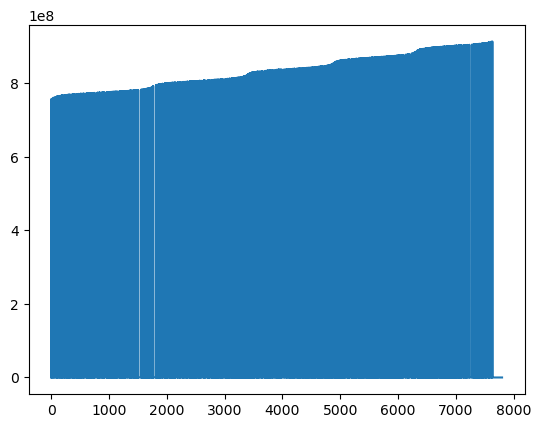

In [504]:
plt.plot(df_original.index[:7800], df_original.iloc[:7800, 0])

In [477]:
reference_date = pd.to_datetime('1992-01-15')
df_original['Time'] = reference_date + pd.to_timedelta(df_original['Time'], unit='s')
df_original.set_index('Time', inplace=True)
df_original = df_original.asfreq('D')
print(df_original)

ValueError: cannot reindex on an axis with duplicate labels

In [256]:
reference_date = pd.to_datetime('1990-01-15')
df_non_zero['Time'] = reference_date + pd.to_timedelta(df_non_zero['Time'], unit='s')
df_non_zero.set_index('Time', inplace=True)
df_non_zero = df_non_zero.asfreq('D')
print(df_non_zero)

ValueError: cannot reindex on an axis with duplicate labels

## Analyze ice data to find correspond distribution

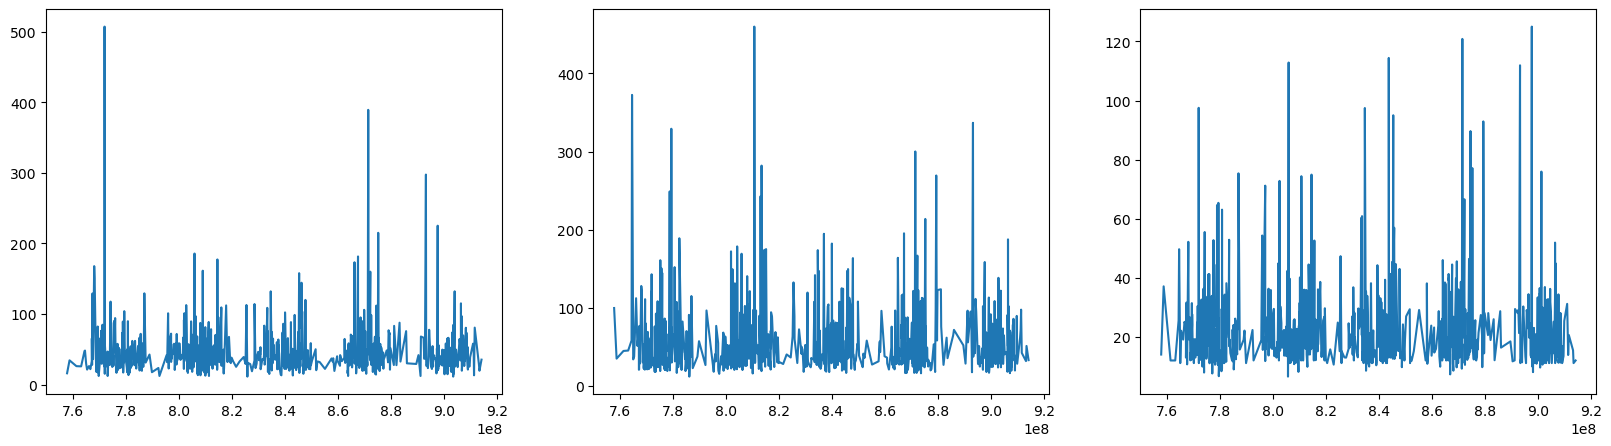

In [227]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
for col in range(1,4):
    axs[col - 1].plot(non_zero[:,0], non_zero[:,col])


In [228]:
import statsmodels.tsa.seasonal as stats

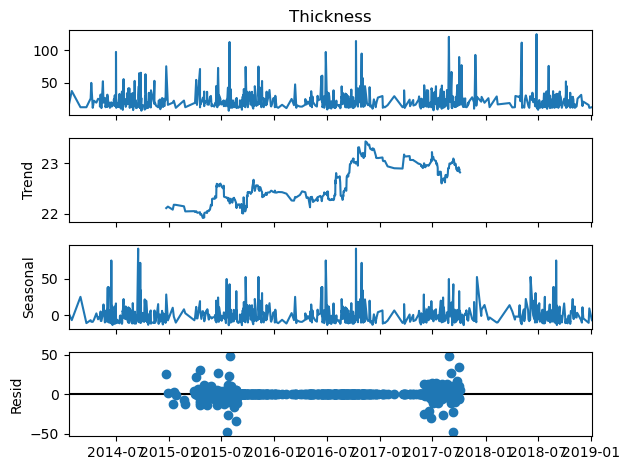

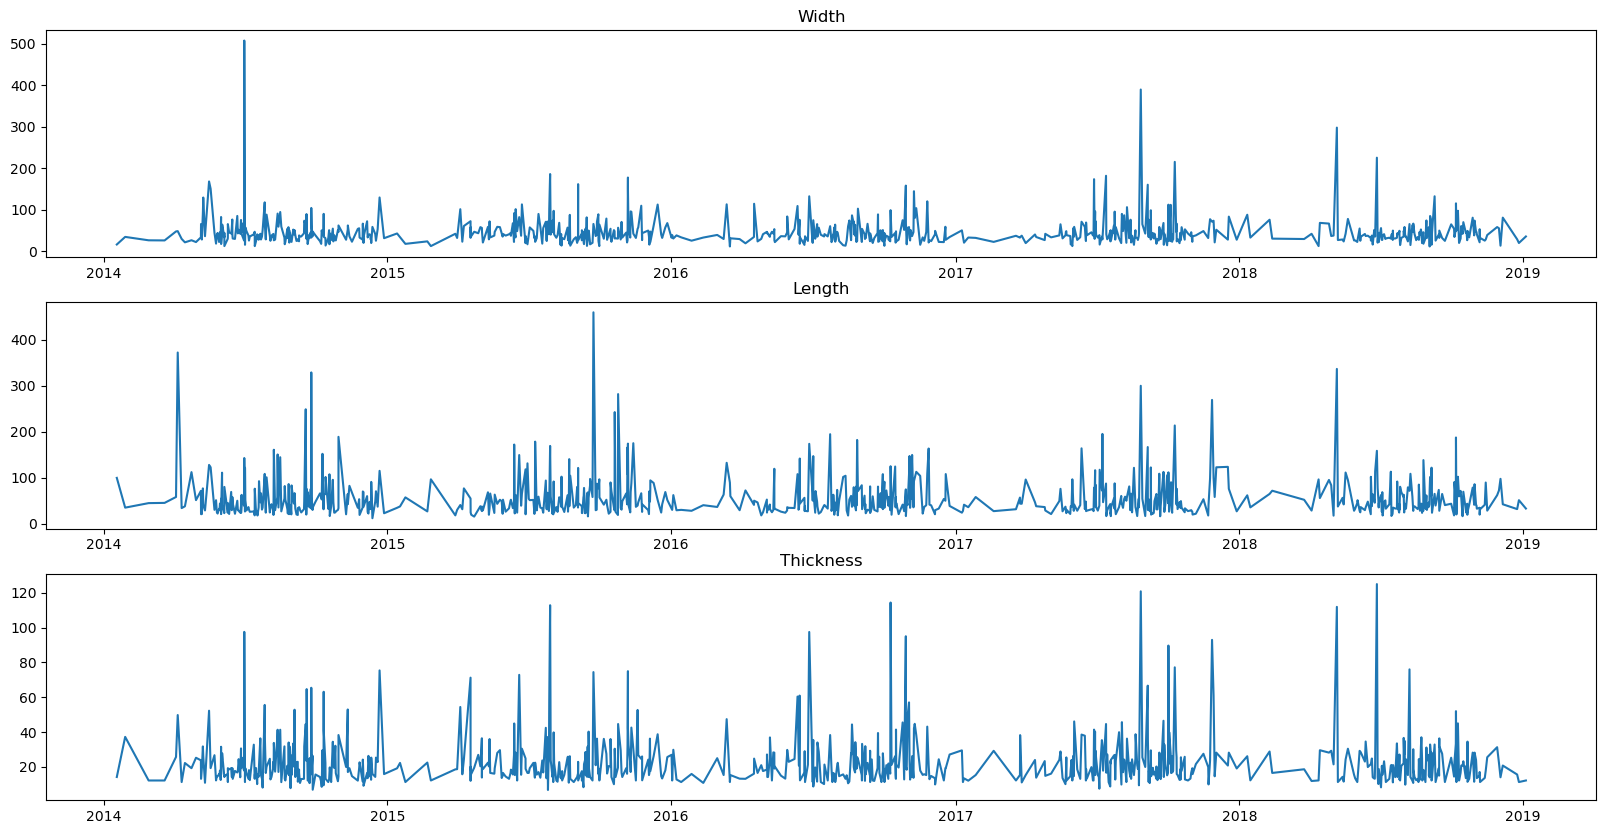

In [342]:
def plot_time_series(data_frame, diff=False):
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(20,10))
    if diff:
        for i in range(3):
            col = i + 3
            plot_df = data_frame[data_frame.columns[col]]
            axs[i].plot(plot_df)
            axs[i].set_title(data_frame.columns[col])
    else:
        for i in range(3):
            col = i
            plot_df = data_frame[data_frame.columns[col]]
            axs[i].plot(plot_df)
            axs[i].set_title(data_frame.columns[col])
    plt.show()
    plt.close(fig)

plot_time_series(df_non_zero)

In [275]:
for col in df_non_zero.columns:
    df_non_zero[col + 'Diff'] = df_non_zero[col].diff()

In [233]:
df_non_zero

,Width,Length,Thickness,WidthDiff,LengthDiff,ThicknessDiff
Time,,,,,,
2014-01-18 01:59:10.781250,15.909895,99.853363,14.091914,NaN,NaN,NaN
2014-01-28 20:24:08.437500,34.237720,35.104782,37.164551,18.327826,-64.748581,23.072637
2014-02-28 00:10:53.906250,26.010483,44.931225,12.086577,-8.227238,9.826443,-25.077973
2014-03-20 13:25:25.781250,25.721203,45.436550,12.086577,-0.289280,0.505325,0.000000
2014-04-04 06:11:57.187500,47.388233,58.263687,25.640795,21.667030,12.827137,13.554217
...,...,...,...,...,...,...
2018-12-02 20:36:05.625000,13.050786,97.754356,13.938859,-42.065597,25.352570,-8.395320
2018-12-05 19:22:15.937500,80.654968,42.435783,20.684101,67.604182,-55.318573,6.745242
2018-12-24 06:13:00.468750,28.485361,31.933449,15.528605,-52.169607,-10.502335,-5.155496


In [474]:
subset_df = df_non_zero[((df_original.index > pd.to_datetime('2015-01-01')) & (df_original.index < pd.to_datetime('2016-01-01')))]
plot_time_series(subset_df, diff=True)# subset_df

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'Timestamp'

In [257]:
import scipy

In [261]:
print(scipy.stats.shapiro(subset_df['Thickness']).pvalue)

2.777921794660652e-17


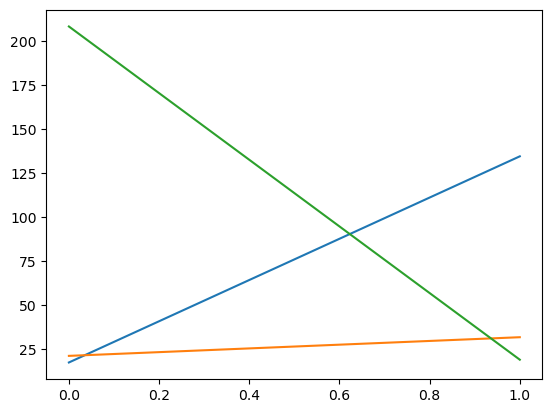

In [471]:
def generate_ice_cube_dimensions(rows):
    generated_data = np.random.lognormal(mean=100, sigma=0.8, size=(rows, 3))
    generated_data = 10**-42 * generated_data
    plt.plot(generated_data)

generate_ice_cube_dimensions(2)

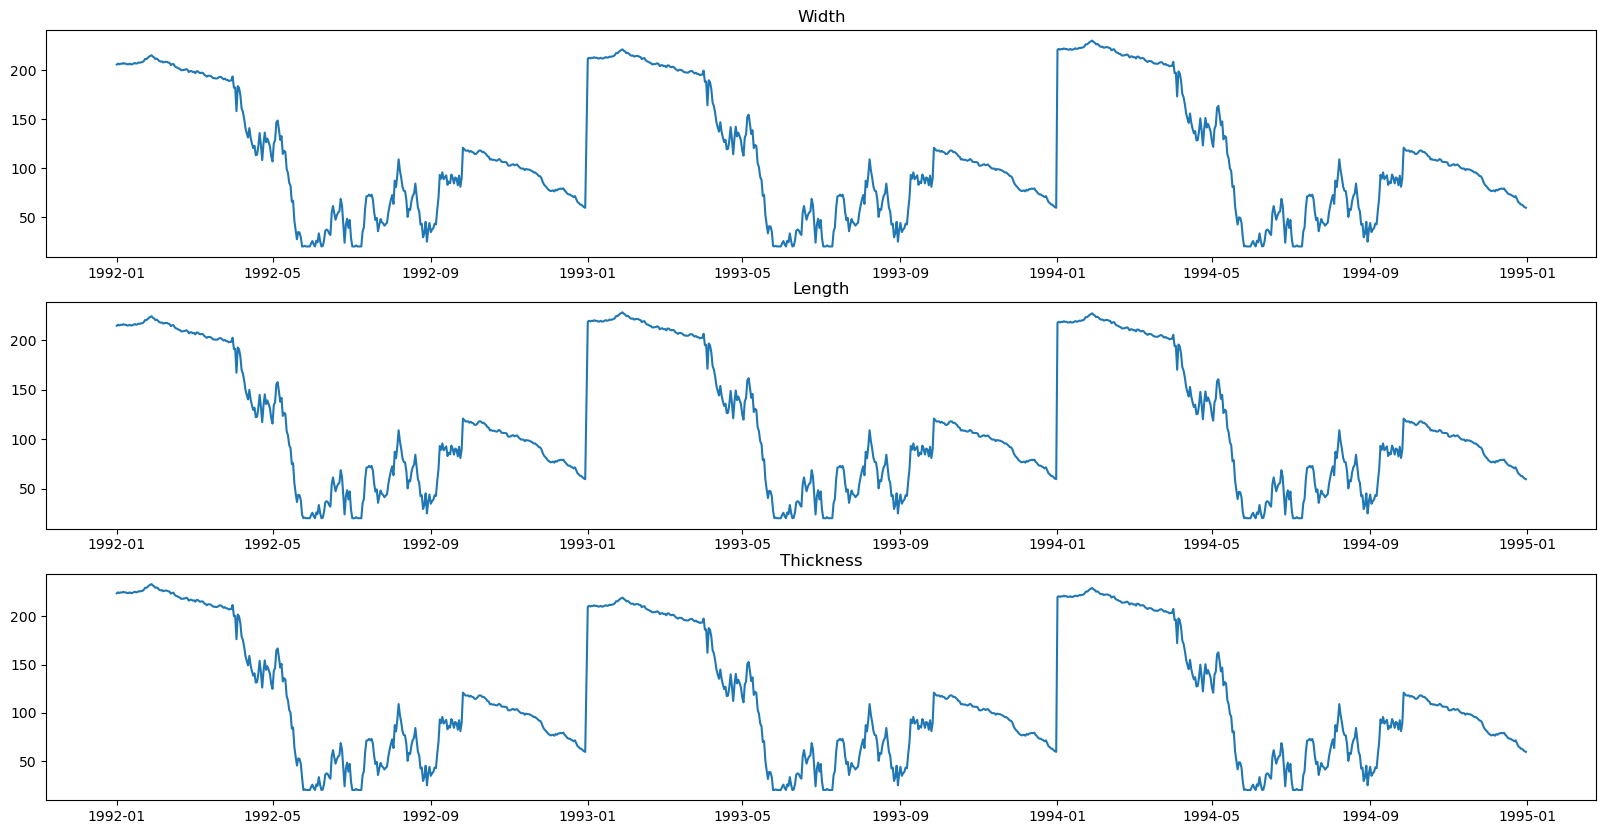

In [469]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# Generate a time series index for one year
original_random = np.random.get_state()

# Define seasonal volatility and glacier thickness bounds (hypothetical values in meters)
def get_glacier_volatility(day_of_year):
    if day_of_year <= 90:   # Q1 (Winter: Ice accumulation, stable)
        return -0.1, 1
    elif day_of_year <= 180:  # Q2 (Spring: Moderate melt begins)
        return 0.3, 10
    elif day_of_year <= 270:  # Q3 (Summer: Heavy ice melt, high fluctuations)
        return -0.1, 10
    else:  # Q4 (Fall: Cooling, ice begins reforming)
        return -0.7, 1

def string_to_ascii(s):
    return sum([ord(char) for char in s])

# Generate time series with controlled range and volatility
def get_glacier_size(year):
    date_range = pd.date_range(start=str(year)+"-01-01", periods=365, freq="D")
    n = len(date_range)
    dimensions = []
    for dimension in ['Width', 'Length', 'Thickness']:
        np.random.seed(year + string_to_ascii(dimension))
        ts_values = [np.random.randint(200, 225, 1)[0]]  # Start with an initial glacier thickness of 60 meters
        np.random.set_state(original_random)
        for i in range(1, n):
            day_of_year = date_range[i].dayofyear
            roc, volatility = get_glacier_volatility(day_of_year)
            
            noise = np.random.normal(0, volatility)  # Scale noise
            new_value = roc + ts_values[i-1] + noise  # Accumulate changes
        
            # Enforce the range
            # new_value = np.clip(new_value, ts_values[0] - )
            new_value = np.clip(new_value, 20, 500)
            ts_values.append(new_value)
        
        # Create Pandas Series
        dimensions.append(pd.Series(ts_values, index=date_range, name=dimension))
    
    dimensions = pd.concat(dimensions, axis=1)
    return dimensions


multiple_timeseries = []
for i in range(1992, 1995):
    multiple_timeseries.append(get_glacier_size(i))
final_df = pd.concat(multiple_timeseries)
plot_time_series(final_df, 0)

In [497]:
day = pd.to_datetime('1992-01-30')

pd.to_timedelta(day - reference_date).total_seconds()

1296000.0

# Code for practice purpose

## J4Practice
Breadth first search approach for finding coastline (It works but takes very long. But it works :) )

In [312]:
from collections import deque

class Tile():
    def __init__(self, row, col):
        self.row = row
        self.col = col
    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    def __hash__(self):
        return hash((self.row, self.col))
    def __str__(self):
        return '{' + str(self.row) + ',' + str(self.col) + '}'
    
def get_all_neighbors(cur_tile: Tile):
    neighbors = []
    for di, dj in [(0,1), (1,0), (0,-1), (-1,0)]:
        new_tile = Tile(cur_tile.row + di, cur_tile.col + dj)
        if new_tile not in visited:
            neighbors.append(new_tile)
    return neighbors

center = Tile(275, 110)
coastline_points = surface_mask.copy()

step = 0
queue = deque([center])
visited = set()
while queue:
    step += 1
    draw_coastlines(coastline_points, step)
    cur_tile = queue.popleft()
    visited.add(cur_tile)
    for neighbor in get_all_neighbors(cur_tile):
        if neighbor in visited:
            continue
        if surface_mask[neighbor.row][neighbor.col] == 1:
            coastline_points[cur_tile.row][cur_tile.col] = 3
            visited.add(neighbor)
        else:
            coastline_points[neighbor.row][neighbor.col] = 2
            queue.append(neighbor)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices